In [1]:
%matplotlib notebook
from __future__ import division

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, ylabel, xlabel, yscale, xscale, legend, subplots, gca, gcf, subplots, figure
from matplotlib.ticker import FormatStrFormatter
from theano import function
import numpy as np
import gzip
import cPickle
from scipy.optimize import minimize
from climin.util import optimizer
from itertools import repeat, cycle, islice, izip, imap, islice
import random
import time
from pprint import pprint
inf = float("inf")

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from schlichtanders.myfunctools import compose, meanmap, meanexpmap, summap, compose_fmap, Average, as_wrapper, AverageExp
from schlichtanders import myfunctools
from schlichtanders.mygenerators import eatN, chunk, chunk_list, every, takeN
from schlichtanders.myplot import add_val, add_point
from schlichtanders.mycontextmanagers import ignored
from IPython.display import IFrame

In [4]:
import theano_models as tm
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm

In [5]:
import theano
import theano.tensor as T
from theano.printing import debugprint
from theano.tensor.shared_randomstreams import RandomStreams

In [6]:
from sqlalchemy import Column, Integer, Unicode, UnicodeText, String, PickleType, Float
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
tm.inputting_references.update(['to_be_randomized'])
tm.inputting_references, tm.outputting_references

({'extra_inputs',
  'flat',
  'inputs',
  'n_data',
  'parameters',
  'parameters_positive',
  'parameters_psumto1',
  'to_be_randomized'},
 {'kl_prior', 'loglikelihood', 'norm_det', 'norm_dets', 'outputs'})

# target

In [9]:
data_target = pm.Gauss(2, init_var=np.exp(-5))  # low variance, almost deterministic
data_target

Gauss { 'inputs': [],
  'outputs': Gauss.outputs,
  'parameters': [mean],
  'parameters_positive': [var]}

In [10]:
param_target_base = pm.Gauss(2, init_mean=[0,0], init_var=2)
param_target_normflows = [dm.PlanarTransform(init__u=[3,6], init_w=[1,3], init_b=-1)]

param_target = param_target_base
for transform in param_target_normflows:
    param_target = tm.normalizing_flow(transform, param_target)  # returns Merge
param_target

normalized_flow { 'inputs': [],
  'norm_det': PlanarTransform.norm_det,
  'outputs': PlanarTransform.outputs,
  'parameters': [b, w, _u, mean],
  'parameters_positive': [var]}

In [11]:
data_target['parameters'] = param_target
target = tm.Merge(data_target, param_target)

---

---

In [12]:
t_sampler = target.function()
n_samples = 10000
training = np.array([t_sampler() for _ in xrange(n_samples)])
targets = training

# model

In [13]:
data_model = pm.Gauss(2, init_var=np.exp(-5))
data_model = tm.Merge(data_model, parameters_positive=None)
data_model

Merge5 { 'inputs': [], 'outputs': Gauss3.outputs, 'parameters': [mean]}

In [14]:
param_model = pm.Mixture(*[pm.Gauss(init_mean=[1,2]), pm.Gauss(init_mean=[-4,-5])])
param_model

Mixture { 'inputs': [],
  'outputs': Mixture.outputs,
  'parameters': [mean, mean],
  'parameters_positive': [var, var],
  'parameters_psumto1': [mixture_probs]}

In [15]:
data_model['parameters'] = param_model
model = tm.Merge(data_model, param_model)

---

---

---

----

In [16]:
# model = Merge(model, Reparameterize(model['parameters_positive'], squareplus, squareplus_inv))
# UncertainWeights uses softplus parameterization
_model = model
_model = tm.Merge(_model, tm.Reparameterize(_model['parameters_positive'], tm.softplus, tm.softplus_inv))
_model = tm.Merge(_model, tm.Reparameterize(_model['parameters_psumto1'], tm.softmax, tm.softmax_inv))
_model = tm.Merge(_model, tm.Center(_model['parameters']))
_model = tm.Merge(_model, tm.Flatten(_model['parameters']))
_model

Merge13 { 'flat': "mean_centered:mean_centered:var_softplus_centered:var_softplus_centered:mixture_probs_softmax_centered",
  'inputs': [],
  'outputs': Gauss3.outputs,
  'parameters': [],
  'parameters_positive': [],
  'parameters_psumto1': []}

# Visualization

In [17]:
_model['flat']

"mean_centered:mean_centered:var_softplus_centered:var_softplus_centered:mixture_probs_softmax_centered"

In [18]:
scatter_kwargs = dict(edgecolors="face", alpha=0.01, s=5000)
outer = dict(i=0)
example_samples = 1000
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    outer['i'] += 1
    ax.clear()
    
    # targets
    ax.plot(targets[:example_samples,0], targets[:example_samples,1], 'k.')
#     ax.scatter(targets[:,0], targets[:,1], c='k', **scatter_kwargs)

    # model
    m_sampler = model.function(givens=givens)
    m_samples = np.array([m_sampler() for _ in xrange(example_samples//2)])
    ax.scatter(m_samples[:,0], m_samples[:,1], c='r',**scatter_kwargs)

    fig.canvas.draw()
    if time_delay is not None:
        time.sleep(time_delay)

In [19]:
values = np.linspace(-10, 10, 10)
Xvalues, Yvalues = np.meshgrid(values, values)
XY = np.c_[Xvalues.flat, Yvalues.flat]

flat = T.vector()
logP = T.stack([theano.clone(target.logP['outputs'],
                             replace={target.logP['inputs'][0]:tm.as_tensor_variable(rv)}) 
                # for some weird reason, _model['flat'] is no longer there in the cloned version
                for rv in XY])

# logP = T.stack(
#     [model['loglikelihood'](as_tensor_variable(rv))['outputs'] - T.inv(model['n_data']) * model['kl_prior']
#     for rv in XY]
# )

target_f_logP = theano.function([], logP)

def plot_distr_target(fig):
    fig.clear()
#     Z = np.reshape(f_logP(flat), Xvalues.shape)        
#     Z = np.reshape(Average(1000)(f_logP, flat), Xvalues.shape)        
    Z = np.reshape(AverageExp(10000)(target_f_logP), Xvalues.shape)        
    for i in range(2):
        ax = fig.add_subplot(1,2,i+1)
        if i==1:
            Z = np.exp(Z)
        h = ax.contourf(Xvalues, Yvalues, Z)
        plt.colorbar(h, ax=ax)
        fig.tight_layout()
        fig.canvas.draw()
# for i in range(20):

In [20]:
values = np.linspace(-10, 10, 10)
Xvalues, Yvalues = np.meshgrid(values, values)
XY = np.c_[Xvalues.flat, Yvalues.flat]

flat = T.vector()
logP = T.stack([theano.clone(model.logP['outputs'],
                             replace={model.logP['inputs'][0]:tm.as_tensor_variable(rv)
                                     ,_model['flat']: flat})
                # for some weird reason, _model['flat'] is no longer there in the cloned version
                for rv in XY])

# logP = T.stack(
#     [model['loglikelihood'](as_tensor_variable(rv))['outputs'] - T.inv(model['n_data']) * model['kl_prior']
#     for rv in XY]
# )

f_logP = theano.function([flat], logP)

def plot_distr(fig, flat):
    fig.clear()
    Z = np.reshape(f_logP(flat), Xvalues.shape)        
#     Z = np.reshape(Average(1000)(f_logP, flat), Xvalues.shape)        
#     Z = np.reshape(AverageExp(5)(f_logP, flat), Xvalues.shape)        
    for i in range(2):
        ax = fig.add_subplot(1,2,i+1)
        if i==1:
            Z = np.exp(Z)
        h = ax.contourf(Xvalues, Yvalues, Z)
        plt.colorbar(h, ax=ax)
        fig.tight_layout()
        fig.canvas.draw()
# for i in range(20):

# optimizer

In [21]:
tm.reduce_all_identities()

batch_size = 200
n_batches = len(targets) // batch_size  # after this many steps we went through the whole data set once

climin_args = izip(imap(lambda x:(x,), chunk(batch_size, cycle(training))), repeat({}))

def weights_regularizer_1epoch():
    for i in range(1, n_batches+1):
        yield 2**(n_batches - i) / (2**n_batches - 1)
        
assert len(list(weights_regularizer_1epoch())) == n_batches

In [22]:
loss = tm.loss_probabilistic(model)

In [23]:
optimizer_kwargs = tm.numericalizeExp(loss, _model['flat'],
#     annealing_combiner=tm.AnnealingCombiner(
#         weights_regularizer=cycle(weights_regularizer_1epoch())
#     ),
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.size, scale=0.1),
#     'profile': True,
#     'mode': 'FAST_RUN'
)

In [24]:
opt = optimizer(
#     identifier='adam',
    identifier="rmsprop",
    step_rate=1e-3,
    momentum=0.9, #0.9,
    args=climin_args,
    **tm.climin_kwargs(optimizer_kwargs)
)

/home/stephan/GitProjects/climin/climin/util.py:151: UserWarning: Argument named f is not expected by <class 'climin.rmsprop.RmsProp'>
  % (i, klass))


<IPython.core.display.Javascript object>


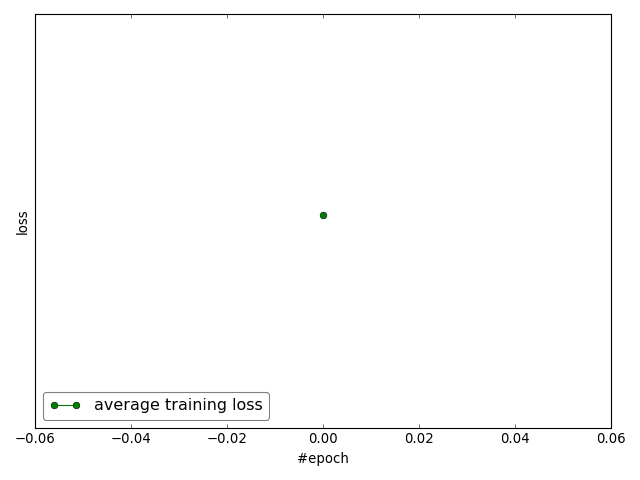

In [25]:
figure()
# plot:
line_train, = plot([], [], 'go-', label="average training loss")
# line_curr_val, = plot([],[], 'bo:', label="avrg current validation loss")
# line_best_val, = plot([], [], 'ko-', label="avrg best validation loss")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
yscale('log')
gca().yaxis.set_minor_formatter(FormatStrFormatter("%.2g"))
ylabel("loss")
xlabel("#epoch")
legend(loc='lower left', fancybox=True, framealpha=0.5)

# start values:
best_parameters = opt.wrt
# best_val_loss = optimizer_kwargs['num_loss'](best_parameters, validation, no_annealing=True)
# best_val_loss /= len(validation)
training_loss = optimizer_kwargs['num_loss'](best_parameters, targets)#, no_annealing=True)
# training_loss /= len(targets)
last_improvement_epoch = opt.n_iter//n_batches

# add_point(line_best_val, last_improvement_epoch, best_val_loss)
# add_point(line_curr_val, last_improvement_epoch, best_val_loss)
add_point(line_train, last_improvement_epoch, training_loss)

<IPython.core.display.Javascript object>


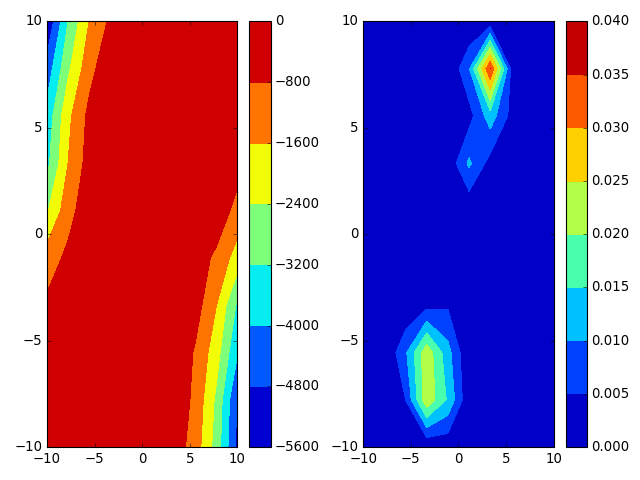

In [26]:
fig_target_distr = figure()
plot_distr_target(fig_target_distr)

THESE ARE SOME OF THE IMPORTANT VALUES. For the targets logP it is clear the meanexpmap is the right one, and it works pretty well.
However for the variational lowerbound officially meanmap is correct, but it gives still impressively worse results
then the meanexpmap. (there is some additional bias due to the prior, but this is not decisive (even with n_data=1))

---

<IPython.core.display.Javascript object>


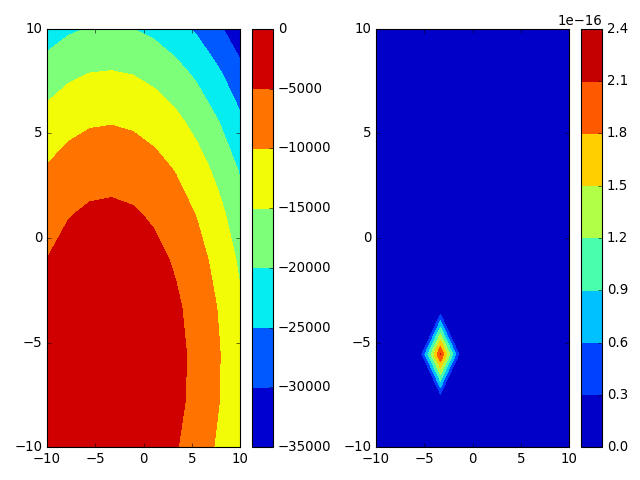

In [27]:
figdistr = figure()
plot_distr(figdistr, _model['flat'].eval())

In [ ]:
fig, ax = subplots()
plot_fit(fig, ax)  #{_model['flat']:optimizer_kwargs['num_parameters']}

In [ ]:
human_readable_parameters = model['parameters'] + model['parameters_positive']
f = theano.function([_model['flat']], human_readable_parameters)
old_num_params = f(opt.wrt)
        
for info in every(n_batches, opt):  #every(n_batches, opt):
    current_epoch = info['n_iter']//n_batches
    # visualize training loss for comparison:
    training_loss = optimizer_kwargs['num_loss'](opt.wrt, targets)#, no_annealing=True)
#         training_loss /= len(targets)
    add_point(line_train, current_epoch, training_loss)


    num_params = f(opt.wrt)
    print "jacobiannames", str(_model['flat'])
    print "jacobian", optimizer_kwargs['num_jacobian'](opt.wrt, targets[:batch_size])
    diff_params = [n - o for n, o in izip(num_params, old_num_params)]
    print("params")
    pprint(dict(zip(map(str, human_readable_parameters), num_params)))
    print("diff")
    pprint(dict(zip(map(str, human_readable_parameters), diff_params)))
    print

    plot_distr(figdistr, opt.wrt)
    plot_fit(fig, ax, {_model['flat']:opt.wrt}, time_delay=None)
    old_num_params = num_params

In [ ]:
%

---

In [ ]:
human_readable_params = (param_model['parameters'] + param_model['parameters_positive']
                         + param_model['parameters_psumto1'])
f_parameters = theano.function([_model['flat']],
                               human_readable_params)
parameters = f_parameters(opt.wrt)
for c in izip(map(str, human_readable_params), parameters):
    print "%30s = %s" % c

In [ ]:
parameters

In [ ]:
best_parameters = None
best_val_loss = inf
last_improvement_epoch = 1
for info in every(n_batches, opt):
    current_epoch = info['n_iter']//n_batches
    if current_epoch - last_improvement_epoch > 50:
        break
    # collect and visualize validation loss for choosing the best model
    val_loss = optimizer_kwargs['num_loss'](opt.wrt, training, no_annealing=True)
    if val_loss < best_val_loss:
        last_improvement_epoch = current_epoch
        best_parameters = opt.wrt
        best_val_loss = val_loss
    
    print zip(model['flat'].name.split(':'), climin_kwargs['fprime'](opt.wrt, training[:100], no_annealing=True))
    plot_fit(fig, ax, givens={model['flat']: opt.wrt}, time_delay=None)
    print best_val_loss,

In [ ]:
%debug

In [ ]:
optimizer_kwargs['flat']

In [ ]:
%timeit optimizer_kwargs['num_jacobian'](best_parameters, targets[:100])

In [ ]:
stats = np.array([optimizer_kwargs['num_jacobian'](best_parameters, targets[:100]) for _ in range(1000)])

In [ ]:
stats[:100]

In [ ]:
plot(stats.T)
pass

In [ ]:
stats.mean(0)

In [ ]:
stats.var(0)

In [ ]:
opt.n_iter

In [ ]:
model.u.eval({model['flat']: best_parameters})

In [ ]:
theano.function([model['flat']], 
                [model.b, target.b,
                 model.w, target.w,
                 model._u, target._u, 
                 param_model_base.mean, 
                 param_target_base.mean, 
                 param_model_base.var, param_target_base.var,
                 data_model.var],
                mode="FAST_COMPILE")(best_parameters)

In [ ]:
best_val_loss

Using the default scipy optimizer, one can see very good, that the problem is ill-defined in that the maximum likelihood solution is a ill-formed solution.